In [8]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np
dir = "/home/zichaohu/catkin_ws/src/SocialNavigation/third_party/graph_navigation/negative_samples/"

In [17]:
collide_idx = []
for i in range(1,50):
    with open(dir + "run_{}.pkl".format(i), "rb") as f:
        path, cost_map, input_map = pickle.load(f)


    cost_map = np.array(cost_map[:-5])
    cost_map = cost_map.reshape(256,256)
    path = np.array(path)
    # check obstacle is not too close
    input_map = input_map[:-5]
    input_map = np.array(input_map)

    input_map = input_map.reshape(6,256,256)
    curr_map = input_map[-2]
    if len(np.nonzero(curr_map[123:133, 123:133])[0]) != 0:
        collide_idx.append(i)
        # print(np.nonzero(curr_map[118:138, 118:138]))
        # plt.figure(figsize=[10,10])
        # plt.imshow(cost_map)
        # break
        continue 
    # print("?")
    # # check too close to obstacle
    # flag = False
    # for i in range(0,len(path),2):
    #     x = int(path[i])
    #     y = int(path[i+1])
    #     idx = np.nonzero(curr_map[y-10:y+10, x-10:x+10])
    #     if len(idx) != 0:
    #         flag = True
    #     cost_map[y][x] = 50
    # if True:
    #     plt.figure(figsize=[10,10])
    #     plt.imshow(cost_map)
print(collide_idx)

[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


In [88]:
# test train negative here
import torch 
import torch.nn as nn
import sys 

sys.path.append('/home/zichaohu/catkin_ws/src/SocialNavigation/BCSAN_new')
sys.path.append('/home/zichaohu/catkin_ws/src/SocialNavigation/third_party/neural-astar/src')
sys.path.append('/home/zichaohu/catkin_ws/src/SocialNavigation/third_party/segmentation_models.pytorch')
sys.path.append('/home/zichaohu/catkin_ws/src/SocialNavigation/scripts')
DEVICE = "cuda:0"
from bc_new import BCNew

MODEL_DIR = "/robodata/zichaohu/training/BCNew/7/ahg/ahg_pred-epoch=170-val_loss=0.00113.ckpt"
model = BCNew(exp_num=7)
    
dict = torch.load(MODEL_DIR, map_location=DEVICE)['state_dict']
model.load_state_dict(dict)
model.to(DEVICE)

loss = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5, amsgrad=True)
optimizer.zero_grad()



In [99]:
with open(dir + "run_{}.pkl".format(5), "rb") as f:
    path, cost_map, input_map = pickle.load(f)

goal_y = int(input_map[-4])
goal_x = int(input_map[-5])

cost_map = np.array(cost_map[:-5])
cost_map = cost_map.reshape(256,256)
path = np.array(path)



# check obstacle is not too close
input_map = input_map[:-5]
input_map = np.array(input_map)
input_map = input_map.reshape(6,256,256)
input_map = torch.as_tensor(input_map).to(DEVICE).unsqueeze(0).float()
# lidar_scans, goal_map, map_design, goal_map_real
lidar_scans = input_map[:,:5]
goal_map = input_map[:,5:6]
map_design = lidar_scans[:,-1:]
goal_map_real = torch.zeros_like(goal_map)
goal_map_real[:,:,goal_y,goal_x] = 1
for i in range(15):
    cost_map, guidance_map, diff_astar_histories, diff_astar_path = model(lidar_scans,goal_map,map_design,goal_map_real)
    
    path_map = torch.clone(diff_astar_histories)
    path_map.requires_grad_ = False
    for i in range(30, len(path), 2):
        x = int(path[i])
        y = int(path[i+1])
        for dx in range(-10,10):
            for dy in range(-10,10):
                path_map[:,:,y+dy,x+dx] = 0

    l = loss(diff_astar_histories, path_map)
    print(l)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()


tensor(0.0017, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<L1LossBackward0>)


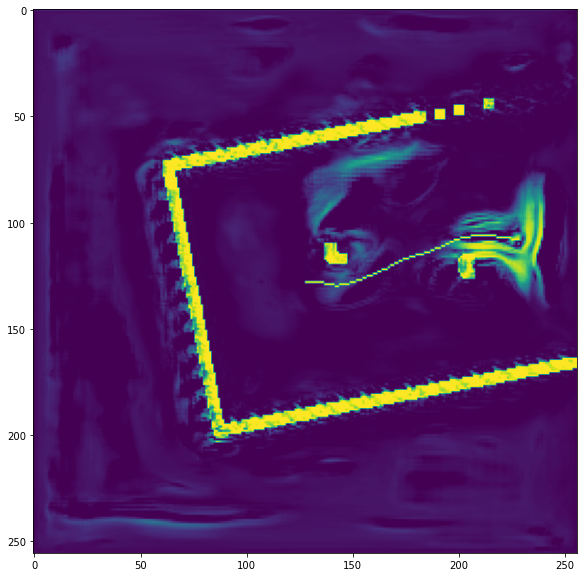

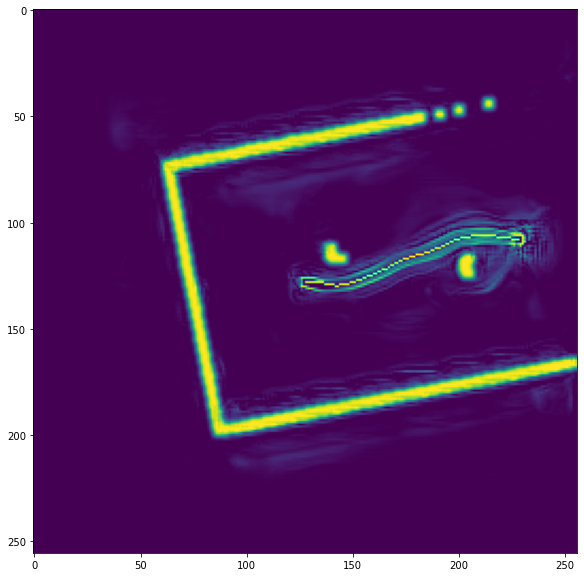

In [100]:
plt.figure(figsize=[10,10])

tmp_cost = cost_map[0,0].detach().cpu().numpy()
for i in range(0, len(path), 2):
    x = int(path[i])
    y = int(path[i+1])
    tmp_cost[y,x] = 50
plt.imshow(tmp_cost)

with open(dir + "run_{}.pkl".format(5), "rb") as f:
    path, cost_map_original, input_map = pickle.load(f)

cost_map_original = np.array(cost_map_original[:-5])
cost_map_original = cost_map_original.reshape(256,256)
for i in range(0, len(path), 2):
    x = int(path[i])
    y = int(path[i+1])
    cost_map_original[y,x] = 50
plt.figure(figsize=[10,10])
plt.imshow(cost_map_original)

(256, 256)
(array([108]), array([228]))


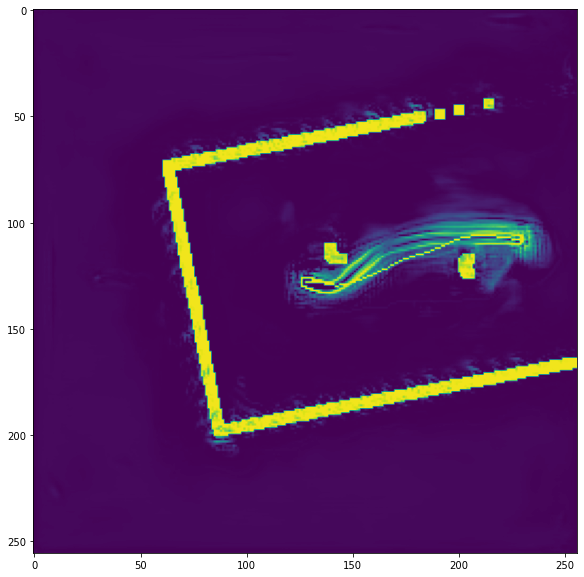

In [94]:
start_img = np.zeros([256,256])
start_img[128,128] = 1
map_goal = goal_map_real.detach().cpu().numpy()[0,0]
print(tmp_cost.shape)
print(np.nonzero(map_goal))
history_map, path_map, _= solve_single(tmp_cost, start_img, map_goal, np.ones([256,256]))

plt.figure(figsize=[10,10])
plt.imshow(path_map + tmp_cost)
plt.show()

In [91]:

def get_neighbor_indices(idx: int, H: int, W: int) -> np.array:
    """Get neighbor indices"""

    neighbor_indices = []
    if idx % W - 1 >= 0:
        neighbor_indices.append(idx - 1)
    if idx % W + 1 < W:
        neighbor_indices.append(idx + 1)
    if idx // W - 1 >= 0:
        neighbor_indices.append(idx - W)
    if idx // W + 1 < H:
        neighbor_indices.append(idx + W)
    if (idx % W - 1 >= 0) & (idx // W - 1 >= 0):
        neighbor_indices.append(idx - W - 1)
    if (idx % W + 1 < W) & (idx // W - 1 >= 0):
        neighbor_indices.append(idx - W + 1)
    if (idx % W - 1 >= 0) & (idx // W + 1 < H):
        neighbor_indices.append(idx + W - 1)
    if (idx % W + 1 < W) & (idx // W + 1 < H):
        neighbor_indices.append(idx + W + 1)

    return np.array(neighbor_indices)


def compute_chebyshev_distance(idx: int, goal_idx: int, W: int) -> float:
    """Compute chebyshev heuristic"""

    loc = np.array([idx % W, idx // W])
    goal_loc = np.array([goal_idx % W, goal_idx // W])
    dxdy = np.abs(loc - goal_loc)
    h = dxdy.sum() - dxdy.min()
    euc = np.sqrt(((loc - goal_loc) ** 2).sum())
    return h + 0.001 * euc


def get_history(close_list: list, H: int, W: int) -> np.array:
    """Get search history"""

    history = np.array([[idx % W, idx // W] for idx in close_list.keys()])
    history_map = np.zeros((H, W))
    history_map[history[:, 1], history[:, 0]] = 1

    return history_map


def backtrack(parent_list: list, goal_idx: int, H: int, W: int) -> np.array:
    """Backtrack to obtain path"""

    current_idx = goal_idx
    path = []
    while current_idx != None:
        path.append([current_idx % W, current_idx // W])
        current_idx = parent_list[current_idx]
    path = np.array(path)
    path_map = np.zeros((H, W))
    path_map[path[:, 1], path[:, 0]] = 1

    return path_map, path

def solve_single(
    pred_cost: np.array,
    start_map: np.array,
    goal_map: np.array,
    map_design: np.array,
    g_ratio: float = 0.5,
) -> list:
    """Solve a single problem"""

    H, W = map_design.shape
    start_idx = np.argwhere(start_map.flatten()).item()
    goal_idx = np.argwhere(goal_map.flatten()).item()
    map_design_vct = map_design.flatten()
    pred_cost_vct = pred_cost.flatten()
    open_list = pqdict()
    close_list = pqdict()
    open_list.additem(start_idx, 0)
    parent_list = {}
    parent_list[start_idx] = None

    num_steps = 0
    while goal_idx not in close_list:
        if len(open_list) == 0:
            print("goal not found")
            return np.zeros_like(goal_map), np.zeros_like(goal_map)
        num_steps += 1
        v_idx, v_cost = open_list.popitem()
        close_list.additem(v_idx, v_cost)
        for (id, n_idx) in enumerate(get_neighbor_indices(v_idx, H, W)):
            if id < 4:
                step_cost = 1
            else:
                step_cost = np.sqrt(2)
            if map_design_vct[n_idx] == 1:
                f_new = (
                    v_cost
                    - (1 - g_ratio)
                    * compute_chebyshev_distance(v_idx, goal_idx, W)
                    + g_ratio * pred_cost_vct[n_idx]
                    + (1 - g_ratio) * compute_chebyshev_distance(n_idx, goal_idx, W)
                    + step_cost
                )

                # conditions for the nodes not yet in the open list nor closed list
                cond = (n_idx not in open_list) & (n_idx not in close_list)

                # condition for the nodes already in the open list but with larger f value
                if n_idx in open_list:
                    cond = cond | (open_list[n_idx] > f_new)

                if cond:
                    try:
                        open_list.additem(n_idx, f_new)
                    except:
                        open_list[n_idx] = f_new
                    parent_list[n_idx] = v_idx

    history_map = get_history(close_list, H, W)
    path_map, path = backtrack(parent_list, goal_idx, H, W)
    return history_map, path_map, path

ok
ok
ok
ok
ok
ok
ok
ok
[0.]


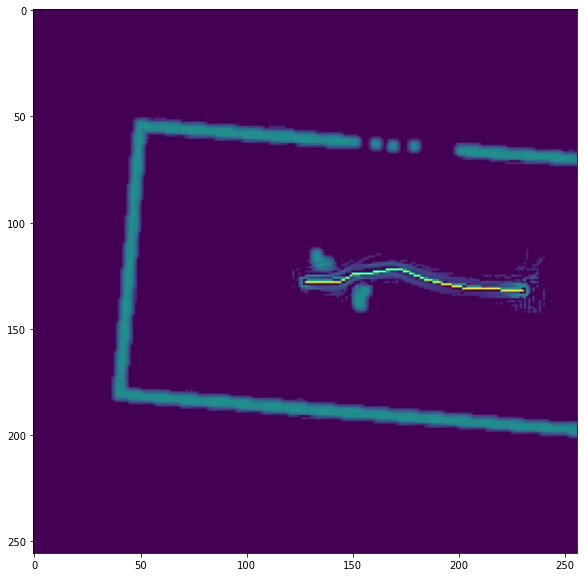

In [73]:
with open(dir + "run_{}.pkl".format(15), "rb") as f:
    path, cost_map, input_map = pickle.load(f)
    input_map = input_map[:-5]
    cost_map = cost_map[:-5]
    
    cost_map = np.array(cost_map)
    input_map = np.array(input_map)

    input_map = input_map.reshape(6,256,256)
    model4_curr_map = input_map[-2]
    model4_goal_map = input_map[-1]
    model4_cost_map = cost_map.reshape(256,256)
    model4_start_img = np.zeros([256,256])
    model4_start_img[128,128] = 1
# model4_cost_map = np.zeros([256,256])
# model4_cost_map[80:140, 140] = 50
model4_cost_map[model4_cost_map<10]= 0
history_map, path_map, _= solve_single(cost_map_original, model4_start_img, model4_goal_map, np.ones([256,256]))
for i in range(0,len(path),2):
    x = int(path[i])
    y = int(path[i+1])
    path_map[y][x] = 2
model4_cost_map[np.nonzero(model4_goal_map)] = 0
model4_cost_map = model4_cost_map = model4_cost_map
print(model4_cost_map[np.nonzero(model4_goal_map)])
plt.figure(figsize=[10,10])
plt.imshow(path_map * 50 + model4_cost_map)
plt.show()